In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import gzip

In [23]:
df = pd.read_csv('../data/dataset.csv')

In [24]:
df.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,predicted_category,sentiment,appVersion
0,326d4bdd-8fc6-4d64-b3bf-ce393fb2ae9b,woww,5,0,NaN,2022-08-16 05:55:38,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN
1,4bbf741b-2f69-43cd-bb76-f9b5f84c83b5,let me know more details about this,3,0,4.5.1143533,2022-08-16 04:44:45,NaN,NaN,CONTENT,NEUTRAL,NaN
2,3cb1136d-e7c6-4999-aa84-fdc7bcdccf56,i've been using this for a while and there's a...,2,0,4.5.1143533,2022-08-16 04:05:27,NaN,NaN,INTERFACE,NEGATIVE,NaN
3,d6f80f05-a6e8-44f3-a380-7c59ed3d208b,good,2,0,4.5.1143533,2022-08-16 00:22:33,NaN,NaN,USER_EXPERIENCE,POSITIVE,NaN
4,eecb277c-c658-4b2d-86c9-77d3a7022cac,mjkobe,5,0,4.5.1143533,2022-08-15 20:08:25,NaN,NaN,USER_EXPERIENCE,NEUTRAL,NaN


In [25]:
columns_to_remove = ['reviewId','score','thumbsUpCount','reviewCreatedVersion','at','replyContent','repliedAt', 'predicted_category','appVersion']

df.drop(columns=columns_to_remove, inplace=True)
df = df.rename(columns={'content': 'review'})

In [26]:
df.head()

,review,sentiment
0,woww,NEUTRAL
1,let me know more details about this,NEUTRAL
2,i've been using this for a while and there's a...,NEGATIVE
3,good,POSITIVE
4,mjkobe,NEUTRAL


In [27]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     53043 non-null  object
 1   sentiment  53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


In [29]:
df.dtypes

review       object
sentiment    object
dtype: object

In [30]:
df['sentiment'].value_counts()

sentiment
POSITIVE    39982
NEUTRAL      7198
NEGATIVE     5863
Name: count, dtype: int64

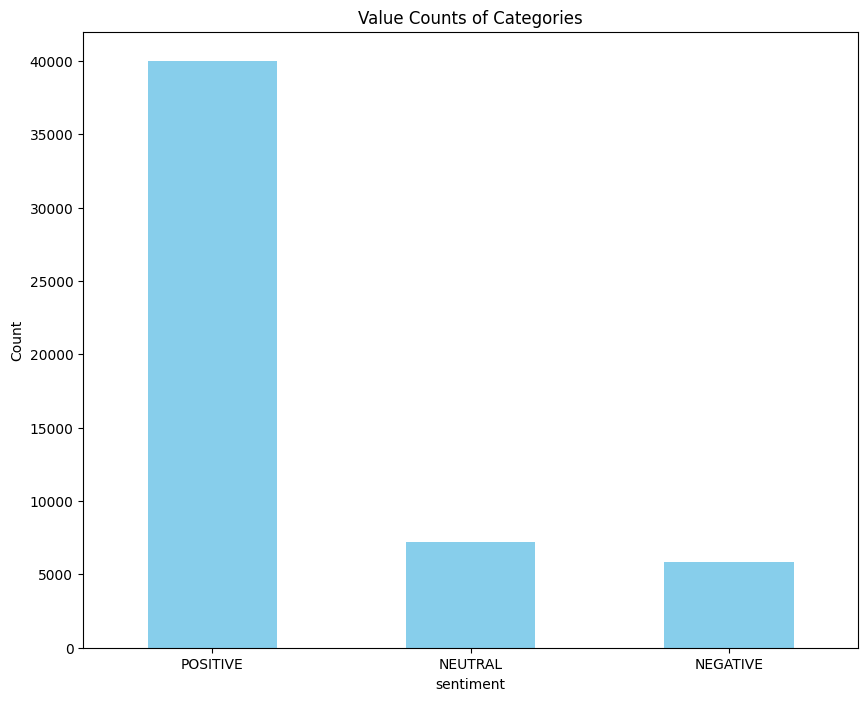

In [31]:
value_counts = df['sentiment'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 8))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Categories')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Handling the class imbalance of the sentiment using Random Under Sampling 

In [32]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state= 0)
df,df['sentiment']=rus.fit_resample(df[['review']],df['sentiment'])

In [33]:
df['sentiment'].value_counts()

sentiment
NEGATIVE    5863
NEUTRAL     5863
POSITIVE    5863
Name: count, dtype: int64

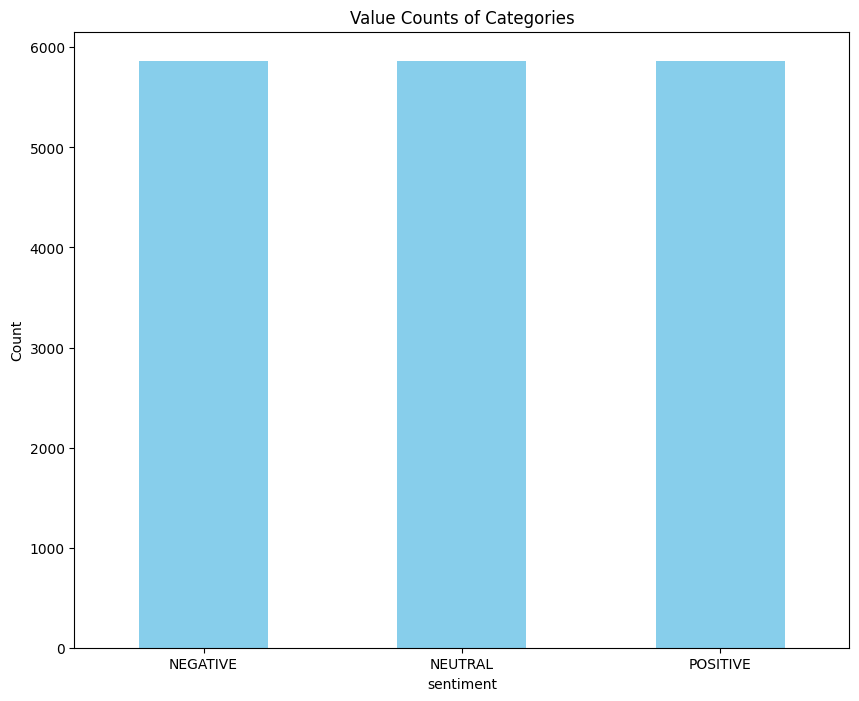

In [34]:
value_counts = df['sentiment'].value_counts()

# Plot the value counts
plt.figure(figsize=(10, 8))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Categories')
plt.xlabel('sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Text cleaning

In [35]:
def remove_characters(text):
    return re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', '', text)
df['review'] = df['review'].apply(remove_characters)

### Removing stop words 

In [36]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df['review'] = df['review'].apply(remove_stopwords)

In [37]:
df

,review,sentiment
2,ive using theres basic bug still fixed scrolli...,NEGATIVE
9,basic search functionality non existent result...,NEGATIVE
26,week daily pick notifications always article i...,NEGATIVE
39,violence golden john fogerty violence oh golde...,NEGATIVE
66,downloaded app intend become medium article wr...,NEGATIVE
...,...,...
13101,point choice topics one place good reads recom...,POSITIVE
37993,pretty good learning,POSITIVE
8423,amazing space read write,POSITIVE
4650,good,POSITIVE


In [38]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

In [39]:
df.head()

,review,sentiment
2,ive using theres basic bug still fixed scrolli...,0
9,basic search functionality non existent result...,0
26,week daily pick notifications always article i...,0
39,violence golden john fogerty violence oh golde...,0
66,downloaded app intend become medium article wr...,0


In [40]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      1749
           1       0.76      0.77      0.77      1806
           2       0.88      0.81      0.84      1722

    accuracy                           0.79      5277
   macro avg       0.80      0.80      0.80      5277
weighted avg       0.80      0.79      0.80      5277



In [39]:
dt_model = DecisionTreeClassifier(class_weight=None, min_samples_leaf=1,min_samples_split=2,random_state=123)

dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1749
           1       0.49      0.84      0.62      1806
           2       0.78      0.44      0.57      1722

    accuracy                           0.60      5277
   macro avg       0.67      0.59      0.59      5277
weighted avg       0.67      0.60      0.59      5277



In [22]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf = RandomForestClassifier()

# Perform GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, verbose=1)
rf_grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters for Random Forest:", rf_grid_search.best_params_)
print("Best Score for Random Forest:", rf_grid_search.best_score_)

# Prediction with best Random Forest model
best_rf_model = rf_grid_search.best_estimator_
y_pred_rf = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best Score for Random Forest: 0.7983268356075374
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      1749
           1       0.78      0.76      0.77      1806
           2       0.87      0.82      0.84      1722

    accuracy                           0.80      5277
   macro avg       0.80      0.80      0.80      5277
weighted avg       0.80      0.80      0.80      5277



In [23]:
best_rf_model

RandomForestClassifier(min_samples_split=5, n_estimators=200)

In [25]:
new_data = ["VERY BAD!!"]
new_data_vectorized = vectorizer.transform(new_data)
predictions = best_rf_model.predict(new_data_vectorized)
predicted_sentiments = label_encoder.inverse_transform(predictions)

print(predicted_sentiments)

['NEGATIVE']


In [42]:
data = {"best_model": best_rf_model, "le": label_encoder, "vectorizer": vectorizer}
with gzip.open('model_steps.pkl.gz', 'wb') as file:
    pickle.dump(data, file)